# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

In [3]:
# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# sanity check
project_config["TKL"]

'NVDA'

# Download TKL data from YF

In [5]:
from datetime import date, timedelta
end_date = date.today() - timedelta(days=1)
start_date = end_date - timedelta(days=int(project_config["HISTORY_DEPTH"]))

In [6]:
tickers_yf = {
    "y_today"     : f"{project_config['TKL']}",
    "NASDAQ"      : "^IXIC",
    "SP500"       : "^GSPC",
    "RealEstate"  : "VNQ",
    "Oil_WTI"     : "CL=F",
    "Gold"        : "GC=F"
}

tickers_fred = {
    "Inflation_CPI" : "CPIAUCSL",
    "Unemployment"  : "UNRATE"
}

In [25]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

# ---- DOWNLOAD FROM YAHOO FINANCE ----
ts_yf = yf.download(
    tickers=list(tickers_yf.values()),
    start=start_date,
    end=end_date,
    auto_adjust=True
)["Close"]

# rename columns to readable names
rename_map = {v: k for k, v in tickers_yf.items()}
ts_yf = ts_yf.rename(columns=rename_map)

# ---- DOWNLOAD FROM FRED ----
import pandas_datareader.data as web
ts_fred = pd.DataFrame()
for col_name, fred_code in tickers_fred.items():
    ts_fred[col_name] = web.DataReader(
        fred_code,
        "fred",
        start_date,
        end_date)

# ---- MERGE ALL ----
ts = pd.concat([ts_yf, ts_fred], axis=1)
#ts = ts_yf

# Fill missing daily values for macro data (monthly)
ts = ts.ffill()   # forward fill
ts = ts.dropna()  # drop any remaining rows

ts = ts.reset_index().rename(columns={"Date": "Date"})

display(ts.head(1))
display(ts.tail(1))

[*********************100%***********************]  6 of 6 completed


Ticker,Date,Oil_WTI,Gold,y_today,RealEstate,SP500,NASDAQ
0,2006-10-09,59.959999,578.400024,0.503037,33.136089,1350.660034,2311.77002


Ticker,Date,Oil_WTI,Gold,y_today,RealEstate,SP500,NASDAQ
4823,2025-12-05,60.080002,4212.899902,182.410004,89.879997,6870.399902,23578.130859


# Turn time series into supprvied learning table

In [9]:
lags = [1,5,10,22,65] # lookback days
windows =  [5,10,22,65] # statistics windows

df = ts.copy()

# Identify columns to generate features for (excluding 'Date')
feature_base_cols = [c for c in df.columns if c not in ['Date']]

for base_col in feature_base_cols: # Iterate over TKL cols

  # Generate lagged features for the current base_col
  for lag in lags:
    df[f"{base_col}_lag_{lag}"] = df[base_col].shift(lag)

  # Generate rolling window statistics for the current base_col
  for window in windows:
    df[f"{base_col}_min_{window}"] = df[base_col].rolling(window=window).min()
    df[f"{base_col}_max_{window}"] = df[base_col].rolling(window=window).max()
    df[f"{base_col}_mean_{window}"] = df[base_col].rolling(window=window).mean()
    df[f"{base_col}_std_{window}"]  = df[base_col].rolling(window=window).std()
    df[f"{base_col}_diff_{window}"] = df[base_col].diff(window)
    df[f"{base_col}_pct_{window}"] = df[base_col].pct_change(window)


df['y_tomorrow'] = df['y_today'].shift(-1)    # tomorrow's close price
df.tail(1)['y_tomorrow'] = -1                 # the TARGET cell
tommorw_date = df.tail(1)['Date']


df.dropna(inplace=True)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit_transform(df)

# Drop 'Date' column from X, along with 'y' and 'y_next'
X = df.drop(['Date','y_tomorrow'], axis=1)
y = df['y_tomorrow']

In [10]:
X_train, X_test = X.iloc[:-2], X.iloc[-1:]
y_train, y_test = y.iloc[:-2], y.iloc[-1:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4756, 180), (1, 180), (4756,), (1,))

# Train, Predict, Evaluate

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror")

xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
pred = xgb.predict(X_test)
mae = mean_absolute_error(y_test, pred)
print("MAE:", mae)

MAE: 1.590850830078125


In [13]:
last_row = X_test # Use X_test which was successfully predicted upon
tomorrow_prediction = xgb.predict(last_row)[0]
#tomorrow_prediction_original_value = scaler.inverse_transform(tomorrow_prediction)
print(f"Stoke: {project_config['TKL']}")
print(f"Date: {tommorw_date.iloc[0].date()}")
print(f"Close Prediction: ${tomorrow_prediction:.2f}")

Stoke: NVDA
Date: 2025-12-05
Close Prediction: $180.82


# Feature selection

<Figure size 1000x600 with 0 Axes>

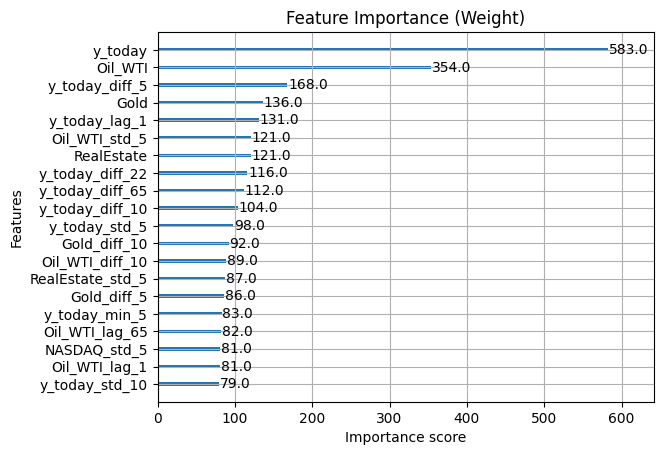

['y_today', 'Oil_WTI', 'y_today_diff_5', 'Gold', 'y_today_lag_1', 'RealEstate', 'Oil_WTI_std_5', 'y_today_diff_22', 'y_today_diff_65', 'y_today_diff_10', 'y_today_std_5', 'Gold_diff_10', 'Oil_WTI_diff_10', 'RealEstate_std_5', 'Gold_diff_5']


In [14]:
import matplotlib.pyplot as plt
import xgboost # Import the xgboost module

# Plot feature importance based on "weight" (number of times a feature appears in a tree)
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Weight)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='weight')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_weight_features_list = df_importance['Feature'].head(15).tolist()
print(top_weight_features_list)

<Figure size 1000x600 with 0 Axes>

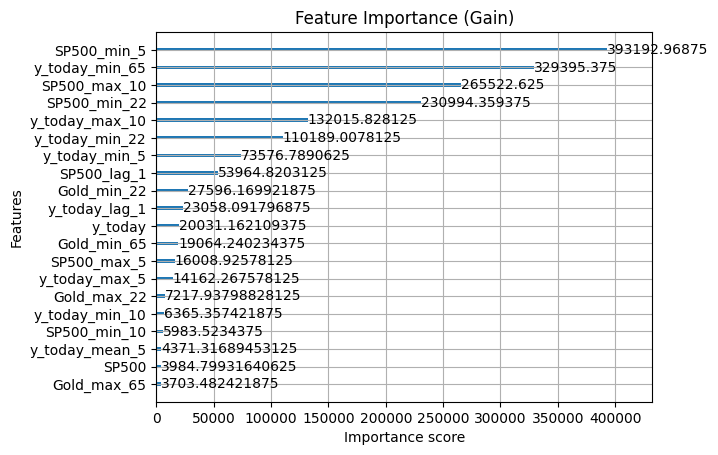

['SP500_min_5', 'y_today_min_65', 'SP500_max_10', 'SP500_min_22', 'y_today_max_10', 'y_today_min_22', 'y_today_min_5', 'SP500_lag_1', 'Gold_min_22', 'y_today_lag_1', 'y_today', 'Gold_min_65', 'SP500_max_5', 'y_today_max_5', 'Gold_max_22']


In [15]:
# OPTIONAL: Plot based on "gain" (average gain of splits which use the feature)
# "Gain" is often more accurate for finding what actually drives the prediction.
plt.figure(figsize=(10, 6))
xgboost.plot_importance(xgb, importance_type='gain', max_num_features=20) # Pass the xgb regressor object
plt.title("Feature Importance (Gain)")
plt.show()

# Get the feature importance dictionary
# importance_type can be 'weight', 'gain', or 'cover'
importance_dict = xgb.get_booster().get_score(importance_type='gain')

# 2. Convert to a Pandas DataFrame for easy sorting and viewing
df_importance = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Score'])

# 3. Sort by Score (High to Low)
df_importance = df_importance.sort_values(by='Score', ascending=False)

# 4. Extract just the names into a Python list (for use in code)
top_gain_features_list = df_importance['Feature'].head(15).tolist()
print(top_gain_features_list)

In [16]:
top_features = list(set(top_gain_features_list) | set(top_weight_features_list))
top_features

['SP500_min_5',
 'SP500_max_5',
 'SP500_max_10',
 'y_today_min_65',
 'y_today_min_5',
 'SP500_lag_1',
 'Gold_min_65',
 'RealEstate_std_5',
 'y_today_min_22',
 'Gold_max_22',
 'y_today',
 'Oil_WTI_std_5',
 'y_today_diff_10',
 'Gold_diff_5',
 'y_today_max_5',
 'Oil_WTI',
 'Gold_min_22',
 'RealEstate',
 'y_today_std_5',
 'Oil_WTI_diff_10',
 'y_today_max_10',
 'Gold',
 'y_today_diff_65',
 'y_today_lag_1',
 'y_today_diff_5',
 'SP500_min_22',
 'y_today_diff_22',
 'Gold_diff_10']

# Final df

In [17]:
final_df = df[['Date','y_tomorrow','y_today'] + top_features]
final_df

Ticker,Date,y_tomorrow,y_today,SP500_min_5,SP500_max_5,SP500_max_10,y_today_min_65,y_today_min_5,SP500_lag_1,Gold_min_65,...,y_today_std_5,Oil_WTI_diff_10,y_today_max_10,Gold,y_today_diff_65,y_today_lag_1,y_today_diff_5,SP500_min_22,y_today_diff_22,Gold_diff_10
65,2007-01-11,0.538335,0.531152,1409.709961,1423.819946,1424.729980,0.482255,0.508079,1414.849976,571.900024,...,0.010836,-8.459999,0.569049,612.400024,0.028115,0.533139,-0.017573,1409.709961,-0.012072,-14.799988
66,2007-01-12,0.539252,0.538335,1412.109985,1430.729980,1430.729980,0.482255,0.508079,1423.819946,572.299988,...,0.012369,-7.539997,0.565534,625.500000,0.046759,0.531152,0.023991,1409.709961,-0.014211,-8.599976
67,2007-01-16,0.527944,0.539252,1412.109985,1431.900024,1431.900024,0.482255,0.508079,1430.729980,576.299988,...,0.012716,-9.840000,0.565534,624.599976,0.044925,0.538335,0.021087,1409.709961,-0.007640,-10.600037
68,2007-01-17,0.484242,0.527944,1414.849976,1431.900024,1431.900024,0.482255,0.527944,1431.900024,579.700012,...,0.004793,-8.809998,0.551323,632.099976,0.031631,0.539252,0.019864,1409.709961,-0.025366,-3.100037
69,2007-01-18,0.487144,0.484242,1423.819946,1431.900024,1431.900024,0.482255,0.484242,1430.619995,579.700012,...,0.022833,-7.840000,0.548726,627.099976,-0.031783,0.527944,-0.048897,1409.709961,-0.078848,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,2025-11-28,179.909988,176.990143,6602.990234,6849.089844,6849.089844,167.001297,176.990143,6812.609863,3431.800049,...,2.187393,-0.139999,190.159409,4218.299805,-4.589508,180.249954,-3.639801,6538.759766,-24.028671,31.399902
4819,2025-12-01,181.449905,179.909988,6705.120117,6849.089844,6849.089844,167.001297,176.990143,6849.089844,3473.699951,...,2.186680,-0.770000,186.589615,4239.299805,-0.239822,176.990143,1.039948,6538.759766,-27.118484,151.699707
4820,2025-12-02,179.580002,181.449905,6765.879883,6849.089844,6849.089844,167.001297,176.990143,6812.629883,3549.399902,...,1.833726,-1.270000,186.509613,4186.600098,7.289429,179.909988,-1.089935,6538.759766,-21.428802,118.300049
4821,2025-12-03,183.380005,179.580002,6812.609863,6849.720215,6849.720215,167.001297,176.990143,6829.370117,3565.800049,...,1.639051,-1.790001,186.509613,4199.299805,8.819138,181.449905,1.769897,6538.759766,-22.898727,137.999756


# Pickle, CSV

In [18]:
df_pickle_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.df.pkl"
df_csv_path = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"

final_df.to_pickle(df_pickle_path)
final_df.to_csv(df_csv_path)